# IMPORT LIBRARIES

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from geopy.geocoders import Nominatim
import time
from pprint import pprint
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA

# CONFIGURATION OF LIBRARIES

In [2]:
plt.figure(figsize=(14,8))

pd.set_option('display.max_columns', 50)

<Figure size 1008x576 with 0 Axes>

# READING DATA FROM SOURCE

Both datasets are stored in the same direcotry with script as csv files. 

In [3]:
dfPolicyData = pd.read_csv("PolicyData.csv", delimiter = ";", encoding='latin-1')
dfPolicyData.set_index("policy_guid", inplace = True)

dfInvoiceData = pd.read_csv("InvoiceData.csv", delimiter = ";")
dfInvoiceData.set_index("invoice_guid", inplace = True)


Premium and amount premium fields are not numberic. They are converted from object to float

In [4]:
dfInvoiceData["amount_premium"] = dfInvoiceData["amount_premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')
dfPolicyData["Premium"] = dfPolicyData["Premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')

In [5]:
dfPolicyData.head()

,Country,VehicleType,VehicleUsage,Power,Weight,VehicleFirstRegistrationYear,Mark,Model,Deductible_general,Fire,Theft,Natural_disasters,Road_assistance,Total_loss,Vandalism,Glass,Accident,Replacement_car,Gender,ClientBirthday,Region,BMClassMOD,Leasing,PolicyIssueDate,PolicyStartDate,PolicyEndDate,PolicyActualEndDate,Nb_of_payments,Premium,Channel,FuelType,avgFuelConsumption,DriveTrain,RenewalIndicator,IsRenewed,BalticRating,Terminated,sales_type
policy_guid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
{E4FD3CD8-4141-4E55-A74C-C983ED7EFD8E},EE,Passenger car,Regular,108,1895,2007,TOYOTA,AVENSIS,191.0,1,1,1,0,1,1,0,1,0,M,1983-10-19 00:00,HARJUMAA,0,0,2015-09-13 00:00,2015-09-13 00:00,2016-09-12 00:00,2016-05-24 00:00,12,261.09,Lean Operator,Gasoline,8.0,Front,0,0,3,1,Renewal
{CD63AD22-81C2-4A86-8E56-AF1084BE49E3},EE,Passenger car,Regular,120,2050,2008,VOLVO,S60,191.0,1,1,1,0,1,1,0,1,0,M,1959-08-11 00:00,PÄRNUMAA,0,0,2015-09-23 00:00,2015-09-23 00:00,2016-09-22 00:00,2015-10-22 00:00,12,297.22,Lean Operator,Diesel,7.0,Front,0,1,0,1,Renewal
{480DDB89-BA11-4219-A92C-330ABC6BE1EC},EE,Passenger car,Regular,125,1970,2012,VOLKSWAGEN,CC,191.0,1,1,1,1,1,1,1,1,0,M,1966-10-17 00:00,HARJUMAA,0,1,2015-09-14 00:00,2015-09-14 00:00,2016-09-13 00:00,2016-09-13 00:00,4,534.22,Direct,Diesel,5.0,Front,0,0,0,0,New sale
{74A1885E-CC4D-435B-B7CF-CAD0287FA814},EE,Passenger car,Regular,85,2510,2007,VOLKSWAGEN,SHARAN,191.0,1,1,1,1,1,1,1,1,0,M,1954-03-08 00:00,TARTUMAA,A1,0,2015-09-20 00:00,2015-09-20 00:00,2016-09-19 00:00,2015-10-04 00:00,12,275.24,Direct,Missing,NaN,Missing,0,1,5,1,New sale
{FF6D78C8-B660-4D58-8A9D-0FD6E32E2A03},EE,Passenger car,Regular,77,1780,2013,SKODA,OCTAVIA,191.0,1,0,1,1,1,1,1,1,0,M,1944-07-30 00:00,JÕGEVAMAA,0,0,2015-11-23 00:00,2015-11-23 00:00,2016-11-22 00:00,2016-04-22 00:00,12,239.77,Direct,Gasoline,NaN,Missing,0,0,2,1,New sale


In [6]:
dfInvoiceData.head()

,payment_status,policy_guid,amount_premium,due_date,paid_date
invoice_guid,,,,,
{55B3ABD8-B64E-498E-A617-3C6E88C4D06F},Paid,{480DDB89-BA11-4219-A92C-330ABC6BE1EC},133.55,2015-12-13 00:00,2015-12-14 00:00
{40544861-68D0-462F-AF9C-8740B2316620},Paid,{480DDB89-BA11-4219-A92C-330ABC6BE1EC},133.55,2016-03-13 00:00,2016-03-14 00:00
{B3C6B66F-280E-413B-8FEE-A804903D2FE8},Paid,{480DDB89-BA11-4219-A92C-330ABC6BE1EC},133.57,2015-09-14 00:00,2015-09-14 00:00
{674FDC26-D0E8-4C20-BB86-1AE9979EB1AA},Paid,{480DDB89-BA11-4219-A92C-330ABC6BE1EC},133.55,2016-06-13 00:00,2016-06-13 00:00
{EE21ECF7-7B70-4DA3-B663-87371073DE18},Paid,{74A1885E-CC4D-435B-B7CF-CAD0287FA814},23.01,2015-09-19 00:00,2015-09-21 00:00


# DATA PREPROCESSING

dfModelData that represents all the possible attributes for input and target features.

In [7]:
dfModelData = dfPolicyData.copy()

# MISSING DATA INPUTATION

In [8]:
def ReplaceMissingDataWithClassifier(dfModelData, aCategoricalFeatures, aContinuousFeatures, sTargetFeature):

    dfModelDataCopy = dfModelData.copy()
    
    aFeaturesX = []
    
    for i in range(len(aCategoricalFeatures)):
        sCategoricalFeature = aCategoricalFeatures[i]

        # to avoid "other" value for multiple attributes
        dfMaskOther = dfModelDataCopy[sCategoricalFeature] == "OTHER"
        
        dfModelDataCopy.loc[dfMaskOther, sCategoricalFeature] = "OTHER_" + str(sCategoricalFeature)
        
        dfCategoricalFeatureClassified = pd.get_dummies(dfModelDataCopy[sCategoricalFeature])
        
        dfModelDataCopy = dfModelDataCopy.join(dfCategoricalFeatureClassified, on= "policy_guid")
        
        aFeaturesX = np.concatenate([aFeaturesX, dfCategoricalFeatureClassified.columns])
 
        
    aFeaturesX = np.concatenate([aFeaturesX, aContinuousFeatures])

    dfTargetFeatureClassified= pd.get_dummies(dfModelDataCopy[sTargetFeature])
    
    dfModelDataCopy = dfModelDataCopy.join(dfTargetFeatureClassified, on= "policy_guid")

    aFeaturesY = np.delete(dfTargetFeatureClassified.columns, np.where(dfTargetFeatureClassified.columns.astype(str) == "Missing"))
    aFeaturesY = np.delete(aFeaturesY, np.where(dfTargetFeatureClassified.columns.isna()))
    
    dfMaskToMissingData = (dfModelData[sTargetFeature].astype(str) == "Missing") | (dfModelData[sTargetFeature].isna())
    dfMissingData = dfModelDataCopy.loc[dfMaskToMissingData]
    
    dfNonMissingData = dfModelDataCopy.drop(dfMissingData.index, inplace = False)
    
    dfX = dfNonMissingData[aFeaturesX]
    dfY = dfNonMissingData[aFeaturesY]

    X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.3, random_state=1)

    oDecTreeModel =  DecisionTreeClassifier()
    oDecTreeModel.fit(X_train, y_train)

    y_pred = oDecTreeModel.predict(X_test)

    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

    print('Recall: ', metrics.recall_score(y_test, y_pred,zero_division=0,  average = 'micro'))

    print('Precision: ', metrics.precision_score(y_test, y_pred,zero_division=0,  average = 'micro'))

    print('F1-Score: ', metrics.f1_score(y_test, y_pred,zero_division=0,  average = 'micro'))
    
    dfX_Missing = dfMissingData[aFeaturesX]
    aPredictionsForMissing = oDecTreeModel.predict(dfX_Missing)
    dfPredictionsForMissing = pd.DataFrame(data = aPredictionsForMissing, columns = aFeaturesY, index = dfMissingData.index)
    
    aPredictedLabels = dfPredictionsForMissing.idxmax(axis=1)
    
    dfModelData.loc[dfMissingData.index,sTargetFeature] = aPredictedLabels

Columns that are NaN in policy dataset

In [9]:
dfPolicyData.columns[dfPolicyData.isna().any()].tolist()

['Deductible_general', 'ClientBirthday', 'BMClassMOD', 'avgFuelConsumption']

Columns that are 'Missing' in policy dataset

In [10]:
dfMissing = dfPolicyData.astype(str) == "Missing"
dfPolicyData.columns[dfMissing.any()].tolist()

['Region', 'FuelType', 'DriveTrain']

Columns that are NaN in invoice dataset

In [11]:
dfInvoiceData.columns[dfInvoiceData.isna().any()].tolist()

[]

Columns that are 'Missing' in invoice dataset

In [12]:
dfMissing = dfInvoiceData.astype(str) == "Missing"
dfInvoiceData.columns[dfMissing.any()].tolist()

[]

## Deductible_general

There are only 2 rows where Deductible_general is missing. 

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [13]:
dfMissingDecutibleGeneral = dfModelData[dfModelData["Deductible_general"].isna()]
dfModelData.drop(dfMissingDecutibleGeneral.index, inplace = True)

## ClientBirthday

There are only 43 rows where ClientBirthday is missing.

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [14]:
dfMissingClientBirthday = dfModelData[dfModelData["ClientBirthday"].isna()]
dfModelData.drop(dfMissingClientBirthday.index, inplace = True)

## BMClassMOD

There are only 14 rows where BMClassMOD is missing.

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [15]:
dfMissingBmClassMod = dfModelData[dfModelData["BMClassMOD"].isna()]
dfModelData.drop(dfMissingBmClassMod.index, inplace = True)

## avgFuelConsumption

There are 27927 rows where avgFuelConsumption is missing.

Since it s a big amount of rows, correlation between avgFuelConsumption and other fields are calculated for non-missing data.

It is found out that avgFuelConsumption has fair linear correlation with the attributes of Power, Weight,  VehicleFirstRegistrationYear and Premium.

Missing data is filled based on random forest classifier model since avgFuelConsumption field contains cardinal-categorical data.

In [16]:
dfMissingAvgFuelConsumption = dfModelData[dfModelData["avgFuelConsumption"].isna()]
dfNonMissingAvgFuelConsumption = dfModelData.drop(dfMissingAvgFuelConsumption.index, inplace = False)

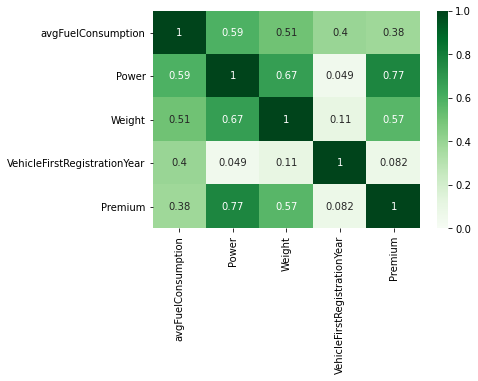

In [17]:
aUniqueAvgFuelConsumption = dfNonMissingAvgFuelConsumption["avgFuelConsumption"].unique()

dfAvgFuelConsumptionClassified = pd.get_dummies(dfNonMissingAvgFuelConsumption["avgFuelConsumption"])
dfNonMissingAvgFuelConsumption[aUniqueAvgFuelConsumption] = dfAvgFuelConsumptionClassified

dfCorr = dfNonMissingAvgFuelConsumption[["avgFuelConsumption", "Power", "Weight", "VehicleFirstRegistrationYear", "Premium"]].corr()

sns.heatmap(dfCorr.abs(), vmin=0, vmax=1, annot = True, cmap="Greens")

In [18]:
ReplaceMissingDataWithClassifier(dfModelData, 
                                ['VehicleType', 'VehicleUsage', 'Mark', 'Model'], 
                                ['Power', 'Weight','VehicleFirstRegistrationYear'], 
                                'avgFuelConsumption')

Accuracy:  0.9311249590029518
Recall:  0.9311249590029518
Precision:  0.9354200988467875
F1-Score:  0.933267587113741


## Region

There are 6727 rows (aprx. 9% of whole dataset).

According to given attributes, it is difficult to build a pattern that can help to predict region.

Regional data may give information about person's financial information. That's why, this attribue is kept in model data but missing rows have been removed from dataset.

In [19]:
dfPolicyDataWithMissingRegion = dfModelData[dfModelData["Region"] == "Missing"]
dfModelData.drop(dfPolicyDataWithMissingRegion.index, inplace = True)

## FuelType

For missing fuel types, we can use policy dataset as a "vehicle" dataset where we can build a classification model to identify fuel type. Logically, fuel type is related with vehicle attributes related features such as 'VehicleType', 'VehicleUsage', 'Power', 'Weight','VehicleFirstRegistrationYear', 'Mark', 'Model'

In [20]:
ReplaceMissingDataWithClassifier(dfModelData, 
                                ['VehicleType', 'VehicleUsage', 'Mark', 'Model'], 
                                ['Power', 'Weight','VehicleFirstRegistrationYear'], 
                                'FuelType')

Accuracy:  0.988257107540173
Recall:  0.988257107540173
Precision:  0.988257107540173
F1-Score:  0.988257107540173


## DriveTrain

There are 22558 rows that have missing information for this field. Since it s a around 36% of whole data and 'DriveTrain' depends on vehicle attributes, we can replace missing data with a classifier.

In [21]:
ReplaceMissingDataWithClassifier(dfModelData, 
                                ['VehicleType', 'VehicleUsage', 'Mark', 'Model'], 
                                ['Power', 'Weight','VehicleFirstRegistrationYear'], 
                                'DriveTrain')

Accuracy:  0.9886334718805666
Recall:  0.9886334718805666
Precision:  0.9892208453573247
F1-Score:  0.9889270714012981


# FEATURE ENCODING

"One-Hot Encoding" is applied when:

The categorical feature is not ordinal.
The number of categorical features is less so one-hot encoding can be effectively applied

"Label Encoding" is applied when:

The categorical feature is ordinal.
The number of categories is quite large as one-hot encoding can lead to high memory consumption

source: 

https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor

In [22]:
def aCreateOneHotEncoding(dfModelData, sCategoricalFeature):
    
    dfTemp = dfModelData[dfModelData[sCategoricalFeature] == "OTHER"]
    dfTemp[sCategoricalFeature] = "Other_" + str(sCategoricalFeature)
    
    dfModelData[dfModelData[sCategoricalFeature] == "OTHER"] = dfTemp
    
    aUniqueValues = dfModelData[sCategoricalFeature].unique()
    
    dfFeatureClassified = pd.get_dummies(dfModelData[sCategoricalFeature])

    dfModelData = dfModelData.join(dfFeatureClassified, on= "policy_guid")

    dfModelData.drop([sCategoricalFeature], axis = 1 , inplace = True)

    return aUniqueValues, dfModelData
    

In [23]:
def aCreateLabelEncoding(dfModelData, sCategoricalFeature):

    oLabelEncoder = LabelEncoder()

    oLabelEncoder.fit(dfModelData[sCategoricalFeature])
    
    dfModelData[sCategoricalFeature] =oLabelEncoder.transform(dfModelData[sCategoricalFeature])
    
    return oLabelEncoder.classes_, dfModelData
    

## TARGET_LABEL

Target labels that represent late payment of invoices of corresponding policy is generated based on following criteria:

1: Paid late at least once

0: Paid always on time

In [24]:
aConditions = [
    (dfInvoiceData["due_date"] < dfInvoiceData["paid_date"]),
    (dfInvoiceData["due_date"] >= dfInvoiceData["paid_date"])
]

dfInvoiceData["isInvoiceLatePaid"] = np.select(aConditions, [1, 0])

oInvocieGroupByPolicy = dfInvoiceData[["policy_guid", "isInvoiceLatePaid"]].groupby(["policy_guid"])

dfInvoiceIssueStatistics = oInvocieGroupByPolicy.agg(["sum"])

dfInvoiceIssueStatistics = dfInvoiceIssueStatistics["isInvoiceLatePaid"] 

dfInvoiceIssueStatistics.columns = ["number_of_late_payments"]

aTargetLabels = [1, 0]
aConditions = [
    (dfInvoiceIssueStatistics["number_of_late_payments"] >= 1),
    (dfInvoiceIssueStatistics["number_of_late_payments"] == 0)
]

dfTargetLabels = pd.DataFrame(data = np.select(aConditions, aTargetLabels), index = dfInvoiceIssueStatistics.index, columns = ["TARGET_LABEL"])

dfModelData = dfTargetLabels.join(dfModelData,  on= "policy_guid", how = "inner")

In [25]:
dfModelData.head()

,TARGET_LABEL,Country,VehicleType,VehicleUsage,Power,Weight,VehicleFirstRegistrationYear,Mark,Model,Deductible_general,Fire,Theft,Natural_disasters,Road_assistance,Total_loss,Vandalism,Glass,Accident,Replacement_car,Gender,ClientBirthday,Region,BMClassMOD,Leasing,PolicyIssueDate,PolicyStartDate,PolicyEndDate,PolicyActualEndDate,Nb_of_payments,Premium,Channel,FuelType,avgFuelConsumption,DriveTrain,RenewalIndicator,IsRenewed,BalticRating,Terminated,sales_type
policy_guid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
{00002943-8C7A-4293-9715-0E4F09C6311D},0,EE,Passenger car,Regular,123,2040,2012,SUBARU,LEGACY,200.0,0,0,0,0,0,0,0,0,0,F,1962-12-05 00:00,HARJUMAA,0,1,2017-01-25 00:00,2017-01-25 00:00,2018-01-24 00:00,2018-01-24 00:00,1,469.55,Broker,Gasoline,8.0,4Drive,0,1,0,0,Renewal
{000118B2-9E9C-4A98-A338-DC31DD7C1F59},1,EE,Passenger car,Regular,127,2850,2009,TOYOTA,LAND CRUISER,200.0,0,0,0,0,0,0,0,0,0,M,1954-12-13 00:00,IDA-VIRUMAA,A1,0,2016-12-30 00:00,2016-12-30 00:00,2017-12-29 00:00,2017-12-29 00:00,12,590.53,Direct,Diesel,9.0,4Drive,1,1,4,0,Upsale
{0001A384-9AAC-44DF-BE77-D247F880B80B},1,EE,Passenger car,Regular,61,1470,2004,HONDA,JAZZ,200.0,0,0,0,0,0,0,0,0,0,M,1942-07-20 00:00,HARJUMAA,0,0,2017-07-28 00:00,2017-07-28 00:00,2018-07-27 00:00,2018-07-27 00:00,1,246.55,Direct,Gasoline,5.0,Front,1,0,0,0,New sale
{0001C1D4-FB9E-4DD3-A539-1F53C3E2BDD9},1,EE,Passenger car,Regular,88,1730,2014,SUZUKI,SX4,191.0,1,0,1,1,1,1,1,1,0,F,1965-09-06 00:00,HARJUMAA,0,0,2014-05-31 00:00,2014-05-31 00:00,2015-05-30 00:00,2015-05-30 00:00,1,282.83,Direct,Gasoline,5.0,Front,0,1,0,0,New sale
{00027C87-4647-41EB-A406-6EB60D5D83D8},0,EE,Passenger car,Regular,80,1693,2002,PEUGEOT,307,191.0,1,0,1,1,1,1,1,1,0,F,1961-07-12 00:00,HIIUMAA,0,0,2015-02-19 00:00,2015-02-19 00:00,2016-02-18 00:00,2016-02-18 00:00,12,251.50,Direct,Gasoline,7.0,Front,1,1,3,0,New sale


## Country

"Country" field is same in whole dataset. It is not considered in model dataset.

In [26]:
dfModelData["Country"].unique()

array(['EE'], dtype=object)

In [27]:
dfModelData.drop(["Country"], axis = 1 , inplace = True)

## VehicleType

By logical judgement, "VehicleType" can be explained by "Weight" and maybe "Mark" and "Model" of vehicle. That's why, this variable is excluded.

In [28]:
dfModelData.drop("VehicleType", axis = 1 , inplace = True)

## VehicleUsage

In [29]:
aVehicleUsages, dfModelData = aCreateOneHotEncoding(dfModelData, "VehicleUsage")

## Mark

Since there are big amount of marks, label encoding is used to not increase the size of dataset massively.

In [30]:
aMarks, dfModelData = aCreateLabelEncoding(dfModelData, "Mark")

## Model

Since there are big amount of models, label encoding is used to not increase the size of dataset massively.

In [31]:
aModels, dfModelData = aCreateLabelEncoding(dfModelData, "Model")

## Region

Region information is converted into geographical coordinates.

In [32]:
# instantiate a new Nominatim client
aUniqueRegions = dfModelData["Region"].unique()
dfRegionsWithCoordinates = pd.DataFrame(index = aUniqueRegions, columns = ["latitude", "longitude"])

oGeolocator = Nominatim(user_agent="tutorial")

for i in range(len(aUniqueRegions)):
    sRegion = aUniqueRegions[i]
    
    oLocation = oGeolocator.geocode(sRegion)
    fLatitue = oLocation.latitude
    fLongitude = oLocation.longitude


    dfRegionsWithCoordinates.loc[sRegion, "latitude"] = fLatitue
    dfRegionsWithCoordinates.loc[sRegion, "longitude"] = fLongitude

dfRegionsWithCoordinates.index.name = "Region"
dfRegionsWithCoordinates.reset_index(level=0, inplace=True)

In [33]:
dfRegionsWithCoordinates

,Region,latitude,longitude
0,HARJUMAA,59.4091,24.7369
1,IDA-VIRUMAA,59.2093,27.413
2,HIIUMAA,58.8902,22.7096
3,TARTUMAA,58.4075,26.7347
4,VÕRUMAA,57.8133,26.9848
5,RAPLAMAA,58.942,24.6984
6,LÄÄNE-VIRUMAA,59.4076,26.3099
7,LÄÄNEMAA,59.098,23.5716
8,PÄRNUMAA,58.3195,24.3026
9,VALGAMAA,57.8689,26.1049


In [34]:
dfModelData = pd.DataFrame(
    data = pd.merge(dfModelData,dfRegionsWithCoordinates, on='Region').values,
    index = dfModelData.index,
    columns = np.concatenate([dfModelData.columns, ['latitude', 'longitude']]))

dfModelData[['latitude', 'longitude']] = dfModelData[['latitude', 'longitude']].astype(float)

dfModelData.drop("Region", axis = 1 , inplace = True)

## Gender

In [35]:
aGenders, dfModelData = aCreateOneHotEncoding(dfModelData, "Gender")

## ClientBirthDay

Client age on policy start date is more relevant than client birthday since we are handling historical data.

In [36]:
dfModelData["ClientAgeOnPolicyStart"] = (pd.to_datetime(dfModelData["PolicyStartDate"])-pd.to_datetime(dfModelData["ClientBirthday"])).astype('<m8[Y]')
dfModelData.drop("ClientBirthday", axis = 1 , inplace = True)

## BMClassMOD

BM Class Mod looks like ordinal categorical data.

In [37]:
aBMClassMODs, dfModelData =  aCreateLabelEncoding(dfModelData, "BMClassMOD")

## PolicyIssueDate

By logical judgement, "PolicyIssueDate" is not related if a person pays late or not. 

In [38]:
dfModelData.drop("PolicyIssueDate", axis = 1 , inplace = True)

## PolicyStartDate

"PolicyStartDate" could be a reason of payment date. Especially day part of the date could be a reason. Maybe persons prefer to pay after their salary. 

This field is converted to following fields: 

1. year, month and day.

2. In addition, expected duration of policies are calculated based on difference between start and end date.

3. Vehicle age on PolicyStartDate

Since this fied is date time field it is removed from model dataset.

In [39]:
dfModelData["PolicyStartYear"] = pd.DatetimeIndex(dfModelData["PolicyStartDate"]).year

dfModelData["PolicyStartMonth"] = pd.DatetimeIndex(dfModelData["PolicyStartDate"]).month

dfModelData["PolicyStartDay"] = pd.DatetimeIndex(dfModelData["PolicyStartDate"]).day

In [40]:
dfModelData["PolicyDurationInMonths"] = (pd.to_datetime(dfModelData["PolicyEndDate"])-pd.to_datetime(dfModelData["PolicyStartDate"])).astype('<m8[M]')

In [41]:
dfModelData["VehicleAgeOnPolicyStart"] = dfModelData["PolicyStartYear"]-dfModelData["VehicleFirstRegistrationYear"]


In [42]:
dfModelData.drop("PolicyStartDate", axis = 1 , inplace = True)

## PolicyEndDate

Newly created "PolicyDurationInMonths" attribute would cover "PolicyEndDate" attribute. That's why, it is removed from model dataset

In [43]:
dfModelData.drop("PolicyEndDate", axis = 1 , inplace = True)

## PolicyActualEndDate

"PolicyActualEndDate" attribute doesn't have a meanining since the prediction algorithm will be running on current time when policy is still active. That's why "PolicyActualEndDate" is removed from model dataset.

In [44]:
dfModelData.drop("PolicyActualEndDate", axis = 1 , inplace = True)

## Channel

Channel may be related with the payment operation as well. It could be so that electronic channels may have more stable payment routine. It is observed that direct and unknown payments have highest late payment rates.

In [45]:
dfChannelStats = dfModelData[["Channel", "TARGET_LABEL"]].groupby(["Channel"]).agg(["sum", "count"])

dfChannelStats = dfChannelStats["TARGET_LABEL"]

dfChannelStats = pd.DataFrame(data = dfChannelStats.values , index  = dfChannelStats.index, columns=["policies paid late", "number of policies"])

dfChannelStats.reset_index(inplace = True)

dfChannelStats["policies paid on time"] = dfChannelStats["number of policies"]-dfChannelStats["policies paid late"]

dfChannelStats["policies paid on time (%)"] = (dfChannelStats["policies paid on time"]/dfChannelStats["number of policies"])*100

dfChannelStats["policies paid late (%)"] = (dfChannelStats["policies paid late"]/dfChannelStats["number of policies"])*100

dfChannelStats

,Channel,policies paid late,number of policies,policies paid on time,policies paid on time (%),policies paid late (%)
0,Broker,1285,7789,6504,83.502375,16.497625
1,Direct,14559,35710,21151,59.229908,40.770092
2,Internet,4065,11622,7557,65.023232,34.976768
3,Lean Operator,673,1997,1324,66.299449,33.700551
4,Partner,1666,4700,3034,64.553191,35.446809
5,Unknown,15,34,19,55.882353,44.117647


In [46]:
aChannels, dfModelData = aCreateOneHotEncoding(dfModelData, "Channel")

## FuelType

In [47]:
aFuelTypes, dfModelData = aCreateOneHotEncoding(dfModelData, "FuelType")

## DriveTrain

In [48]:
aDriveTrains, dfModelData = aCreateOneHotEncoding(dfModelData, "DriveTrain")

## sales_type

In [49]:
aSalesTypes, dfModelData = aCreateOneHotEncoding(dfModelData, "sales_type")

Finally all data is in numerical format. 

In [50]:
dfModelData = dfModelData.astype(float)

dfModelData.head()

,TARGET_LABEL,Power,Weight,VehicleFirstRegistrationYear,Mark,Model,Deductible_general,Fire,Theft,Natural_disasters,Road_assistance,Total_loss,Vandalism,Glass,Accident,Replacement_car,BMClassMOD,Leasing,Nb_of_payments,Premium,avgFuelConsumption,RenewalIndicator,IsRenewed,BalticRating,Terminated,...,M,ClientAgeOnPolicyStart,PolicyStartYear,PolicyStartMonth,PolicyStartDay,PolicyDurationInMonths,VehicleAgeOnPolicyStart,Broker,Direct,Internet,Lean Operator,Partner,Unknown,CNG,Diesel,Diesel-Hybrid,Electricity,Gasoline,Gasoline-Hybrid,4Drive,Front,Rear,New sale,Renewal,Upsale
policy_guid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
{00002943-8C7A-4293-9715-0E4F09C6311D},0.0,123.0,2040.0,2012.0,59.0,375.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,469.55,8.0,0.0,1.0,0.0,0.0,...,0.0,54.0,2017.0,1.0,25.0,11.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
{000118B2-9E9C-4A98-A338-DC31DD7C1F59},1.0,61.0,1470.0,2004.0,19.0,346.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,246.55,5.0,1.0,0.0,0.0,0.0,...,1.0,75.0,2017.0,7.0,28.0,11.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
{0001A384-9AAC-44DF-BE77-D247F880B80B},1.0,88.0,1730.0,2014.0,60.0,552.0,191.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,282.83,5.0,0.0,1.0,0.0,0.0,...,0.0,48.0,2014.0,5.0,31.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
{0001C1D4-FB9E-4DD3-A539-1F53C3E2BDD9},1.0,117.0,2116.0,2008.0,38.0,45.0,191.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,315.43,7.0,0.0,0.0,5.0,1.0,...,0.0,59.0,2015.0,6.0,17.0,11.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
{00027C87-4647-41EB-A406-6EB60D5D83D8},1.0,118.0,2050.0,2011.0,65.0,448.0,191.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,277.96,7.0,1.0,0.0,2.0,1.0,...,1.0,49.0,2016.0,5.0,2.0,11.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Variance Inflation Factor

A rule of thumb for interpreting the variance inflation factor:

1 = not correlated.
Between 1 and 5 = moderately correlated.
Greater than 5 = highly correlated.

Source:

https://www.investopedia.com/terms/v/variance-inflation-factor.asp

https://www.statisticshowto.com/variance-inflation-factor/

# PREDICTIVE MODEL

In [134]:
gc_dec_TEST_RATIO = 0.3
gc_dec_VALIDATION_RATIO = 0.2

In [135]:
aFeaturesY = ["TARGET_LABEL"]
aFeaturesX = dfModelData.drop(aFeaturesY, axis = 1, inplace = False).columns


dfX = dfModelData[aFeaturesX]

dfY = dfModelData[aFeaturesY]

X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=gc_dec_TEST_RATIO, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(
    dfX,
    dfY,
    test_size=gc_dec_TEST_RATIO,
    shuffle=True,
    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_val,
    y_val,
    test_size=gc_dec_VALIDATION_RATIO * gc_dec_TEST_RATIO,
    shuffle=True,
    random_state=1)
    

## Data Scaling

In [136]:
oScaler = StandardScaler()
X_train = oScaler.fit_transform(X_train)
X_val = oScaler.transform(X_val)
X_test = oScaler.transform(X_test)

## Principle Component Analysis

In [137]:
oPca = PCA(n_components=10)

aPcaTrain = oPca.fit_transform(X_train)
aPcaVal = oPca.transform(X_val)
aPcaTest = oPca.transform(X_test)


## Random Forest Classifier

In [138]:
oRandForestModel =  RandomForestClassifier()
oRandForestModel.fit(aPcaTrain, y_train.values.ravel())

y_pred = oRandForestModel.predict(aPcaTest)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred,zero_division=0,  average = 'micro'))
print('Precision: ', metrics.precision_score(y_test, y_pred,zero_division=0,  average = 'micro'))
print('F1-Score: ', metrics.f1_score(y_test, y_pred,zero_division=0,  average = 'micro'))

Accuracy:  0.6802651433498599
Recall:  0.6802651433498599
Precision:  0.6802651433498599
F1-Score:  0.6802651433498599


## Decision Tree Classifier

In [139]:
oDecTreeModel =  DecisionTreeClassifier()
oDecTreeModel.fit(aPcaTrain, y_train)

y_pred = oDecTreeModel.predict(aPcaTest)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred,zero_division=0,  average = 'micro'))
print('Precision: ', metrics.precision_score(y_test, y_pred,zero_division=0,  average = 'micro'))
print('F1-Score: ', metrics.f1_score(y_test, y_pred,zero_division=0,  average = 'micro'))

Accuracy:  0.6074046130631602
Recall:  0.6074046130631602
Precision:  0.6074046130631602
F1-Score:  0.6074046130631602


## Multi Layer Perception

In [145]:
oMlpModel = tf.keras.Sequential()

oMlpModel.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(aPcaTrain.shape[1],)))
oMlpModel.add(Dropout(0.2))
oMlpModel.add(Dense(200, activation='relu', kernel_initializer='he_normal'))
oMlpModel.add(Dropout(0.2))
oMlpModel.add(Dense(1, activation='sigmoid'))

oEarlyStop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0 , patience = 20)
        
oMlpModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

oMlpModel.fit(aPcaTrain, 
              y_train, 
              epochs=200, 
              batch_size=128, 
              verbose=1, 
              validation_data= (aPcaVal, y_val),
              callbacks=[oEarlyStop]
             )

Epoch 1/200
318/318 [==============================] - 2s 5ms/step - loss: 0.6803 - accuracy: 0.6432 - val_loss: 0.5887 - val_accuracy: 0.6721
Epoch 2/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5986 - accuracy: 0.6667 - val_loss: 0.5838 - val_accuracy: 0.6798
Epoch 3/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5885 - accuracy: 0.6740 - val_loss: 0.5805 - val_accuracy: 0.6886
Epoch 4/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5838 - accuracy: 0.6762 - val_loss: 0.5793 - val_accuracy: 0.6882
Epoch 5/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5810 - accuracy: 0.6835 - val_loss: 0.5784 - val_accuracy: 0.6913
Epoch 6/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5807 - accuracy: 0.6793 - val_loss: 0.5796 - val_accuracy: 0.6836
Epoch 7/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5797 - accuracy: 0.6805 - val_loss: 0.5791 - val_accuracy: 0.6844

Epoch 58/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5623 - accuracy: 0.6947 - val_loss: 0.5757 - val_accuracy: 0.6867
Epoch 59/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5620 - accuracy: 0.6944 - val_loss: 0.5734 - val_accuracy: 0.6894
Epoch 60/200
318/318 [==============================] - 1s 5ms/step - loss: 0.5610 - accuracy: 0.6961 - val_loss: 0.5733 - val_accuracy: 0.6848
Epoch 61/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5607 - accuracy: 0.6936 - val_loss: 0.5741 - val_accuracy: 0.6828
Epoch 62/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5620 - accuracy: 0.6949 - val_loss: 0.5738 - val_accuracy: 0.6844
Epoch 63/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5620 - accuracy: 0.6959 - val_loss: 0.5742 - val_accuracy: 0.6867
Epoch 64/200
318/318 [==============================] - 1s 4ms/step - loss: 0.5622 - accuracy: 0.6937 - val_loss: 0.5722 - val_accuracy:

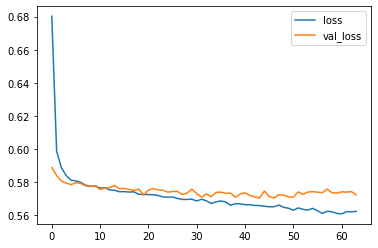

In [146]:
dfMlpHistory = pd.DataFrame(oMlpModel.history.history)

dfMlpHistory[["loss", "val_loss"]].plot()

In [148]:
y_pred = oMlpModel.predict(aPcaTest)
y_pred = np.argmax(y_pred, axis=-1)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred,zero_division=0,  average = 'micro'))
print('Precision: ', metrics.precision_score(y_test, y_pred,zero_division=0,  average = 'micro'))
print('F1-Score: ', metrics.f1_score(y_test, y_pred,zero_division=0,  average = 'micro'))

Accuracy:  0.6358590213408062
Recall:  0.6358590213408062
Precision:  0.6358590213408062
F1-Score:  0.6358590213408062
